# Convection Diffusion Fractional PDE

This notebook contains a Julia implementation of the meethod described in the following conference paper:

Jacky Cresson, Fernando Jiménezk, Sina Ober-Blöbaum<br>
<i>Modelling of the Convection-Diffusion Equation through Fractional Restricted Calculus of Variations</i><br>
IFAC-PapersOnLine, Volume 54, Issue 9, 2021, Pages 482-487<br>
https://doi.org/10.1016/j.ifacol.2021.06.105


In [43]:
# load packages
using FFTW
using ToeplitzMatrices
using LinearAlgebra
using Plots
using NLsolve
using ProgressMeter

In [32]:
# Constants and forcing term
K = -.15        # diffusion
gamma = .4     # advection
xi = 0.0        # reaction
alpha = .5     # fractional
beta = .49     # fractional
force(u) = 0.   # external forces

# discretisation parameters
dt = 0.1# time step size
dx = 0.1 # spacial step size
N = 800 # number of time steps (not including initial condition)
M = 100; # number of inner spacial gridpoints 

tt = dt*(0:N)   # time grid
xx = dx*(0:M+1); # space grid with boundary
(-K)/gamma-dx       # mesh Peclet condition (>=0)

0.2749999999999999

In [33]:
# fractional factorial

function An(alpha,n)
    A=zeros(n+1)
    A[1] = 1
    for j=1:n
        A[j+1] = (j-1 - alpha)*A[j]/j
    end
    return A
end
    

An (generic function with 1 method)

In [34]:
# discretisation matrix for central differences d_{xx} for homogeneous Dirichlet boundary conditions

T2=Circulant([-2.;1;zeros(Int,M-3);1]) # discerete central differences d_{xx}
T2 = T2*Matrix{Float64}(I, M, M)       # convert to matrix

# Dirichlet conditions
T2[1,end]=0
T2[end,1]=0;

In [35]:
# discretisation matrix for fractional spacial derivative for homogeneous Dirichlet boundary conditions

T1=Circulant(An(alpha+beta,M))         
T1 = T1*Matrix{Float64}(I, M, M)       # convert to matrix
T1 = tril(T1)[1:end-1,:];

In [36]:
# spacial discretisation
rhs(U) = force.(U) - xi.*U - K/dx^2 * T2*U - gamma/(dx^(alpha+beta)) * T1*U

rhs (generic function with 1 method)

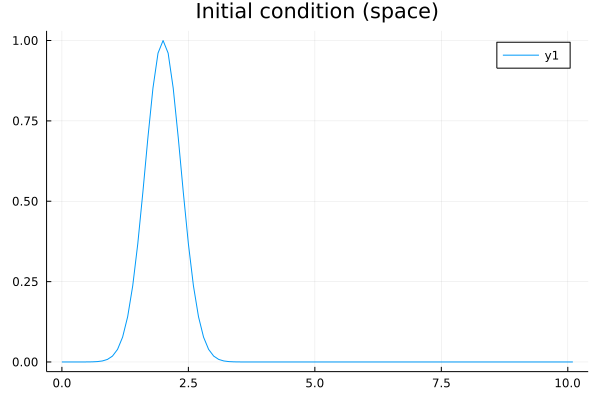

In [37]:
# initial condition
u0 = exp.(-4.0*(xx.-2.0).^2)
plot(xx,u0,title="Initial condition (space)")

In [38]:
# initialisation of scheme
U = Array{Float64, 2}(undef, N+1, M) # pre-allocating memory
U[1,:] = u0[2:end-1];                # set initial condition

In [47]:
# run the fractional scheme over time
@showprogress for j = 2:N+1
    objective = Uj -> 1/dt^(alpha+beta)*transpose(transpose(reverse(An(alpha+beta,j-1)))*[U[1:j-1,:];transpose(Uj)]) - rhs(Uj)
    U[j,:] = nlsolve(objective,U[j-1,:]).zero
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


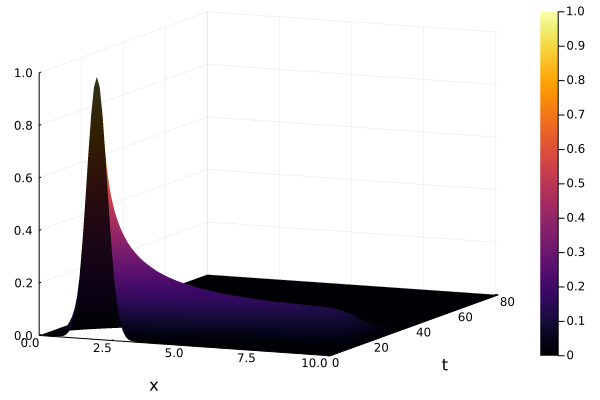

In [57]:
# plot result
UFull = [zeros(N+1) U zeros(N+1)]; # add Dirichlet boundary
plot(xx,tt,UFull,st=:surface,xlabel="x",ylabel="t")
#savefig("PDE_plot_result.png")

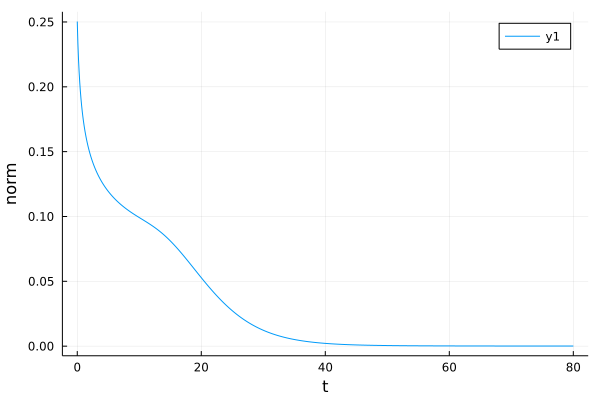

In [61]:
# decay of discrete l2 norm
plot(tt,dx.*sqrt.(sum(U.^2,dims=2)),xlabel="t",ylabel="norm")
#savefig("Decay_Discrete_L2_Norm.pdf")